#Sentiment Analysis Twitter with [snscrape] and [vader]

Referensi :

*   https://www.youtube.com/watch?v=jtIMnmbnOFo
*   https://towardsdatascience.com/step-by-step-twitter-sentiment-analysis-in-python-d6f650ade58d


## Install Modules and Import Library

In [ ]:
!pip install textblob
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

# data scraping
import snscrape.modules.twitter as sntwitter

# sentiment analysis
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# chart
import matplotlib.pyplot as plt

# data cleaning
import re
import string

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Data Scraping

Library = `snscrape`

data scraping twitter menurut search keyword \
Time Range = 1 Januari 2022 - 20 April 2022 \
Keyword =
*   ui ux
*   android develop

Hasil data scraping akan disimpan di runtime ini

Karena proses run lama, gapapa kalo section ini gausah di run lagi. Langsung import dataset hasil scraping di section bawahnya


# **UI/UX**

In [ ]:
# Scraping UI UX
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "ui ux lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_uiux.csv')

## Sentiment Keyword = ui ux

### Import Dataset Hasil Scraping

In [ ]:
#import dataset ui ux
url='https://drive.google.com/file/d/1nsZMXWgWVSk13MQ6WlNmbtlXKKeUHWkL/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "ui ux lang:id since:2022-01-01"

uiux = pd.read_csv(file_name)
uiux.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-19 21:46:27+00:00,Zevrinaea,Ga mempermasalahkan vouchernya. Appsnya dibuka...
1,1,2022-04-19 16:23:33+00:00,retpelvet,"Aplikasi lemot, ui/ux jelek, ngabisin batre, i..."
2,2,2022-04-19 13:43:25+00:00,TalenstaMW,juoohhh!! Aku bangga dengan tanganku :') awkao...
3,3,2022-04-19 12:33:08+00:00,UXJOBS_IMEA,uxjobs (#India) UI/UX Developer - Hiring Cafe ...
4,4,2022-04-19 12:31:37+00:00,mukharomf,Alhamdulillah banget bisa keterima di UI. UI/UX


In [ ]:
uiux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4773 non-null   object
 1   Date        4762 non-null   object
 2   User        4762 non-null   object
 3   Tweet       4762 non-null   object
dtypes: object(4)
memory usage: 149.3+ KB


### Data Preprocessing

*   Menghapus Row yang Null
*   menghapus Row yang sama (duplicate row)
*   Memfilter Retweet, tag, dan link
*   Mengubah Tweet ke dalam bentuk lowercase
*   Menghapus Kolom yang tidak digunakan



In [ ]:
tw_list = uiux

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-19 21:46:27+00:00,Zevrinaea,ga mempermasalahkan vouchernya. appsnya dibuka...,Ga mempermasalahkan vouchernya. Appsnya dibuka...
1,1,2022-04-19 16:23:33+00:00,retpelvet,"aplikasi lemot, ui/ux jelek, ngabisin batre, i...","Aplikasi lemot, ui/ux jelek, ngabisin batre, i..."
2,2,2022-04-19 13:43:25+00:00,TalenstaMW,juoohhh!! aku bangga dengan tanganku :') awkao...,juoohhh!! Aku bangga dengan tanganku :') awkao...
3,3,2022-04-19 12:33:08+00:00,UXJOBS_IMEA,uxjobs (#india) ui/ux developer - hiring cafe ...,uxjobs (#India) UI/UX Developer - Hiring Cafe ...
4,4,2022-04-19 12:31:37+00:00,mukharomf,alhamdulillah banget bisa keterima di ui. ui/ux,Alhamdulillah banget bisa keterima di UI. UI/UX


Note :

[Tweet] = Hasil Filter \
[text] = Raw Tweet

In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

### Sentiment Analysis

Library = vader

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0

# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-19 21:46:27+00:00,Zevrinaea,ga mempermasalahkan vouchernya. appsnya dibuka...,0.0,0.0,neutral,0.000,1.000,0.000,0.0000
1,2022-04-19 16:23:33+00:00,retpelvet,"aplikasi lemot, ui/ux jelek, ngabisin batre, i...",0.0,0.0,negative,0.213,0.787,0.000,-0.4019
2,2022-04-19 13:43:25+00:00,TalenstaMW,juoohhh!! aku bangga dengan tanganku :') awkao...,0.0,0.0,positive,0.000,0.794,0.206,0.5972
3,2022-04-19 12:33:08+00:00,UXJOBS_IMEA,uxjobs (#india) ui/ux developer - hiring cafe ...,0.0,0.0,neutral,0.000,1.000,0.000,0.0000
4,2022-04-19 12:31:37+00:00,mukharomf,alhamdulillah banget bisa keterima di ui. ui/ux,0.0,0.0,neutral,0.000,1.000,0.000,0.0000
5,2022-04-19 11:53:46+00:00,po_onjati,kenapa gw gamilih ui ux ato web aja ya,0.0,0.0,neutral,0.000,1.000,0.000,0.0000
6,2022-04-19 11:32:09+00:00,z___vyi,ui nya bikin pening padet banner promo.\nux ny...,0.0,0.0,negative,0.051,0.949,0.000,-0.1531
7,2022-04-19 10:59:09+00:00,eksoterm,"biaya server, pajak, perawatan dan pengembanga...",0.0,0.0,positive,0.000,0.898,0.102,0.3612
8,2022-04-19 10:48:20+00:00,ruangdiskusi48,ui sama ux nya masih banyak yang perlu dibener...,0.0,0.0,neutral,0.000,1.000,0.000,0.0000
9,2022-04-19 10:01:45+00:00,hyperfem_,thee urge buat ngoreksi design anak ui yang sl...,0.0,0.0,neutral,0.000,1.000,0.000,0.0000


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
2,2022-04-19 13:43:25+00:00,TalenstaMW,juoohhh!! aku bangga dengan tanganku :') awkao...,0.0,0.0,positive,0.0,0.794,0.206,0.5972
7,2022-04-19 10:59:09+00:00,eksoterm,"biaya server, pajak, perawatan dan pengembanga...",0.0,0.0,positive,0.0,0.898,0.102,0.3612
27,2022-04-18 23:25:52+00:00,haroon_uiux,yes in sha allah!,0.0,0.0,positive,0.0,0.501,0.499,0.4574


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
1,2022-04-19 16:23:33+00:00,retpelvet,"aplikasi lemot, ui/ux jelek, ngabisin batre, i...",0.0,0.0,negative,0.213,0.787,0.0,-0.4019
6,2022-04-19 11:32:09+00:00,z___vyi,ui nya bikin pening padet banner promo.\nux ny...,0.0,0.0,negative,0.051,0.949,0.0,-0.1531
13,2022-04-19 09:17:00+00:00,Jessran,#klwp\nhishoot: \npreset:pi po evolution ui ux...,0.0,0.0,negative,0.265,0.735,0.0,-0.5574


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-19 21:46:27+00:00,Zevrinaea,ga mempermasalahkan vouchernya. appsnya dibuka...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
3,2022-04-19 12:33:08+00:00,UXJOBS_IMEA,uxjobs (#india) ui/ux developer - hiring cafe ...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
4,2022-04-19 12:31:37+00:00,mukharomf,alhamdulillah banget bisa keterima di ui. ui/ux,0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,270,5.67
positive,818,17.18
neutral,3674,77.15


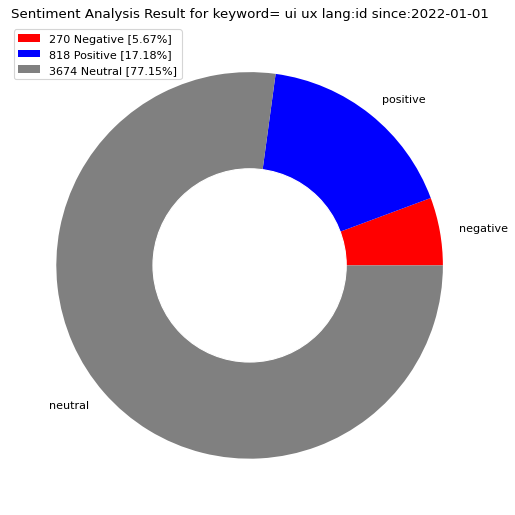

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Kursus UI/UX**

In [ ]:
query = "kursus ui ux lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_kursusuiux.csv')

In [ ]:
url='https://drive.google.com/file/d/1HF4K1c_jNeYP0OKz6_Qu984KWDuYEZON/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "kursus ui ux lang:id since:2022-01-01"

kursusUiUx = pd.read_csv(file_name)
kursusUiUx.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-04 10:51:18+00:00,uphei,"@rayzapratama @hrdbacot Background acc, kerja ..."
1,1,2022-04-01 08:05:00+00:00,worksfess,Work! Ada gak yg bukan jurusan IT/komputer/DKV...
2,2,2022-03-28 03:01:07+00:00,digital_skola,Digital Skola? Siapatuh? Ituloh startup edukas...
3,3,2022-03-21 12:08:31+00:00,araskakma,"Nama: Binar Academy\n\nProduk: Kursus UI/UX, W..."
4,4,2022-03-20 02:40:08+00:00,piwwraa,aku ngerjain kursus ui/ux susah bener woi😭😭😭😭😭...


In [ ]:
kursusUiUx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  13 non-null     int64 
 1   Date        13 non-null     object
 2   User        13 non-null     object
 3   Tweet       13 non-null     object
dtypes: int64(1), object(3)
memory usage: 544.0+ bytes


In [ ]:
tw_list = kursusUiUx

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-04 10:51:18+00:00,uphei,"background acc, kerja di konsultan jadi bagi...","@rayzapratama @hrdbacot Background acc, kerja ..."
1,1,2022-04-01 08:05:00+00:00,worksfess,work! ada gak yg bukan jurusan it/komputer/dkv...,Work! Ada gak yg bukan jurusan IT/komputer/DKV...
2,2,2022-03-28 03:01:07+00:00,digital_skola,digital skola? siapatuh? ituloh startup edukas...,Digital Skola? Siapatuh? Ituloh startup edukas...
3,3,2022-03-21 12:08:31+00:00,araskakma,"nama: binar academy\n\nproduk: kursus ui/ux, w...","Nama: Binar Academy\n\nProduk: Kursus UI/UX, W..."
4,4,2022-03-20 02:40:08+00:00,piwwraa,aku ngerjain kursus ui/ux susah bener woi😭😭😭😭😭...,aku ngerjain kursus ui/ux susah bener woi😭😭😭😭😭...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-04 10:51:18+00:00,uphei,"background acc, kerja di konsultan jadi bagi...",0.000,0.0,positive,0.000,0.924,0.076,0.4019
1,2022-04-01 08:05:00+00:00,worksfess,work! ada gak yg bukan jurusan it/komputer/dkv...,0.000,0.0,positive,0.000,0.889,0.111,0.4122
2,2022-03-28 03:01:07+00:00,digital_skola,digital skola? siapatuh? ituloh startup edukas...,0.000,0.0,positive,0.000,0.908,0.092,0.5158
3,2022-03-21 12:08:31+00:00,araskakma,"nama: binar academy\n\nproduk: kursus ui/ux, w...",0.000,0.0,neutral,0.000,1.000,0.000,0.0000
4,2022-03-20 02:40:08+00:00,piwwraa,aku ngerjain kursus ui/ux susah bener woi😭😭😭😭😭...,0.000,0.0,neutral,0.000,1.000,0.000,0.0000
5,2022-03-02 19:08:41+00:00,icarusfalls76,iyaa kursus tp ada alurnya musti belajar tah...,0.625,0.5,positive,0.000,0.903,0.097,0.3971
6,2022-02-06 09:37:26+00:00,jeongpretty_,bljr ui/ux design atau ikut kursusnya gitu tpi...,0.000,0.0,neutral,0.000,1.000,0.000,0.0000
7,2022-01-21 15:31:16+00:00,BrandZe1,"engga kok, saran aja ui/ux banyakin bikin por...",0.000,0.0,negative,0.033,0.967,0.000,-0.1027
8,2022-01-21 15:26:10+00:00,sedikit_arab,"ui/ux itu ya harus ada ""taste"" sendiri nder, ...",0.000,0.0,neutral,0.000,1.000,0.000,0.0000
9,2022-01-19 13:34:43+00:00,hirediox,kursus jangka pendek (mostly bayar tp kadang ...,0.500,0.5,neutral,0.000,1.000,0.000,0.0000


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-04 10:51:18+00:00,uphei,"background acc, kerja di konsultan jadi bagi...",0.0,0.0,positive,0.0,0.924,0.076,0.4019
1,2022-04-01 08:05:00+00:00,worksfess,work! ada gak yg bukan jurusan it/komputer/dkv...,0.0,0.0,positive,0.0,0.889,0.111,0.4122
2,2022-03-28 03:01:07+00:00,digital_skola,digital skola? siapatuh? ituloh startup edukas...,0.0,0.0,positive,0.0,0.908,0.092,0.5158


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
7,2022-01-21 15:31:16+00:00,BrandZe1,"engga kok, saran aja ui/ux banyakin bikin por...",0.0,0.0,negative,0.033,0.967,0.0,-0.1027


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
3,2022-03-21 12:08:31+00:00,araskakma,"nama: binar academy\n\nproduk: kursus ui/ux, w...",0.0,0.0,neutral,0.0,1.0,0.0,0.0
4,2022-03-20 02:40:08+00:00,piwwraa,aku ngerjain kursus ui/ux susah bener woi😭😭😭😭😭...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
6,2022-02-06 09:37:26+00:00,jeongpretty_,bljr ui/ux design atau ikut kursusnya gitu tpi...,0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,1,7.69
positive,4,30.77
neutral,8,61.54


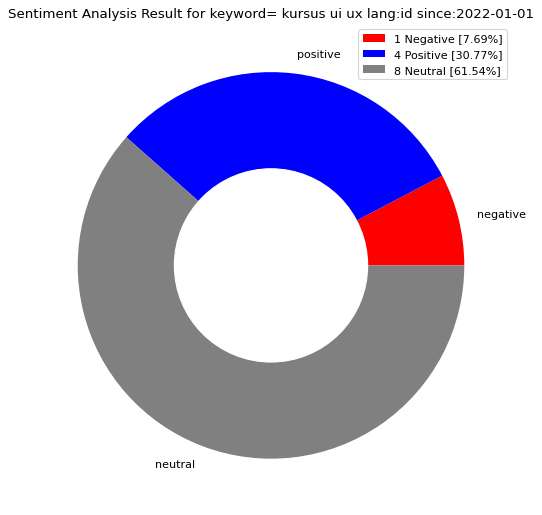

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **UI/UX Course**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "ui ux course lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_uiuxcourse.csv')

In [ ]:
url='https://drive.google.com/file/d/1ffTLrYTl7SbS67uopj6xCBJBOf9BqmMG/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "ui ux course lang:id since:2022-01-01"

UiUxcourse = pd.read_csv(file_name)
UiUxcourse.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-17 10:19:23+00:00,alannvnt,Evolusi Perilaku Manusia pt. 1\n\nMemasuki cou...
1,1,2022-04-16 13:21:25+00:00,mediaevent__,*[UI/UX Web Design Competition - GradIT]*\n \n...
2,2,2022-04-16 08:30:25+00:00,annnnnnnnnnnsie,@psHazwan Tak buang lagi. Frame. Nak amik cert...
3,3,2022-04-16 04:23:35+00:00,ITDevCOMPFEST,"sabtu pagi ini, tim UI/UX mengawali hari merek..."
4,4,2022-04-16 03:14:15+00:00,codingfess,"Code; saran course tentang ui/ux, ux writing, ..."


In [ ]:
UiUxcourse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  73 non-null     int64 
 1   Date        73 non-null     object
 2   User        73 non-null     object
 3   Tweet       73 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.4+ KB


In [ ]:
tw_list = UiUxcourse

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-17 10:19:23+00:00,alannvnt,evolusi perilaku manusia pt. 1\n\nmemasuki cou...,Evolusi Perilaku Manusia pt. 1\n\nMemasuki cou...
1,1,2022-04-16 13:21:25+00:00,mediaevent__,*[ui/ux web design competition - gradit]*\n \n...,*[UI/UX Web Design Competition - GradIT]*\n \n...
2,2,2022-04-16 08:30:25+00:00,annnnnnnnnnnsie,tak buang lagi. frame. nak amik cert lain pla...,@psHazwan Tak buang lagi. Frame. Nak amik cert...
3,3,2022-04-16 04:23:35+00:00,ITDevCOMPFEST,"sabtu pagi ini, tim ui/ux mengawali hari merek...","sabtu pagi ini, tim UI/UX mengawali hari merek..."
4,4,2022-04-16 03:14:15+00:00,codingfess,"code; saran course tentang ui/ux, ux writing, ...","Code; saran course tentang ui/ux, ux writing, ..."


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-17 10:19:23+00:00,alannvnt,evolusi perilaku manusia pt. 1\n\nmemasuki cou...,0.0,0.0,neutral,0.00,1.000,0.000,0.0000
1,2022-04-16 13:21:25+00:00,mediaevent__,*[ui/ux web design competition - gradit]*\n \n...,0.0,0.0,positive,0.00,0.900,0.100,0.5684
2,2022-04-16 08:30:25+00:00,annnnnnnnnnnsie,tak buang lagi. frame. nak amik cert lain pla...,0.0,0.0,neutral,0.00,1.000,0.000,0.0000
3,2022-04-16 04:23:35+00:00,ITDevCOMPFEST,"sabtu pagi ini, tim ui/ux mengawali hari merek...",0.0,0.0,negative,0.13,0.870,0.000,-0.4019
4,2022-04-16 03:14:15+00:00,codingfess,"code; saran course tentang ui/ux, ux writing, ...",0.0,0.0,neutral,0.00,1.000,0.000,0.0000
5,2022-04-15 10:33:36+00:00,tinasugiyarto,salam bang dari sy yg br bermodalkan mini cou...,0.0,0.0,neutral,0.00,1.000,0.000,0.0000
6,2022-04-14 16:17:55+00:00,ARF_9,"hello, boleh ikut untuk ui /ux course classn...",0.0,0.0,neutral,0.00,1.000,0.000,0.0000
7,2022-04-11 10:21:37+00:00,tinasugiyarto,kek nya ui ux design sih kaaak. pernah ikut ...,0.0,0.0,neutral,0.00,1.000,0.000,0.0000
8,2022-04-10 13:26:31+00:00,siiyncan,"bisa di coursera, buildwithangga, atau di ig ...",0.0,0.0,neutral,0.00,1.000,0.000,0.0000
9,2022-04-10 06:35:37+00:00,metawingss,imo kalau gaji masih 2 jt mending invest soft...,0.0,0.0,positive,0.00,0.826,0.174,0.5994


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
1,2022-04-16 13:21:25+00:00,mediaevent__,*[ui/ux web design competition - gradit]*\n \n...,0.0,0.0,positive,0.0,0.900,0.100,0.5684
9,2022-04-10 06:35:37+00:00,metawingss,imo kalau gaji masih 2 jt mending invest soft...,0.0,0.0,positive,0.0,0.826,0.174,0.5994
15,2022-04-02 15:52:55+00:00,collegemenfess,info course ui/ux gratis dong tia [cm],0.0,0.0,positive,0.0,0.526,0.474,0.5423


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
3,2022-04-16 04:23:35+00:00,ITDevCOMPFEST,"sabtu pagi ini, tim ui/ux mengawali hari merek...",0.0,0.0,negative,0.130,0.870,0.0,-0.4019
58,2022-01-24 11:55:55+00:00,collegemenfess,[cm] aku kan niatnga mau dalemin design ui/ux ...,0.0,0.0,negative,0.055,0.945,0.0,-0.1027


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-17 10:19:23+00:00,alannvnt,evolusi perilaku manusia pt. 1\n\nmemasuki cou...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
2,2022-04-16 08:30:25+00:00,annnnnnnnnnnsie,tak buang lagi. frame. nak amik cert lain pla...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
4,2022-04-16 03:14:15+00:00,codingfess,"code; saran course tentang ui/ux, ux writing, ...",0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,2,2.74
positive,16,21.92
neutral,55,75.34


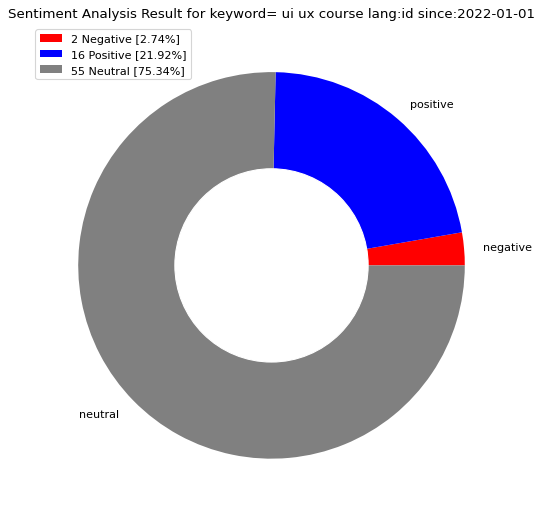

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Bootcamp UI/UX**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "bootcamp ui ux lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_bootcampuiux.csv')

In [ ]:
url='https://drive.google.com/file/d/1PB2k8H_zo2BkgRw0r4QDZsoE6VFKDtxm/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "bootcamp ui ux lang:id since:2022-01-01"

bootcampUiUx = pd.read_csv(file_name)
bootcampUiUx.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-17 11:01:52+00:00,RachmalinD,"Bukber bersama ui ux gang, biasanya daily stan..."
1,1,2022-04-16 15:25:00+00:00,worksfess,"Work! Aku kepikiran switch karier, pengennya k..."
2,2,2022-04-16 14:52:04+00:00,busy_koala,"@worksfess Ada dong yg gratis, seleksinya maya..."
3,3,2022-04-16 14:00:58+00:00,latifaskaa,"3. Ikut bootcamp\n\nEh, ini aku ga promosi ya ..."
4,4,2022-04-16 14:00:54+00:00,latifaskaa,Saran bootcamp ui/ux gratis ?\n\nBelum ada sih...


In [ ]:
bootcampUiUx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  105 non-null    int64 
 1   Date        105 non-null    object
 2   User        105 non-null    object
 3   Tweet       105 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.4+ KB


In [ ]:
tw_list = bootcampUiUx

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-17 11:01:52+00:00,RachmalinD,"bukber bersama ui ux gang, biasanya daily stan...","Bukber bersama ui ux gang, biasanya daily stan..."
1,1,2022-04-16 15:25:00+00:00,worksfess,"work! aku kepikiran switch karier, pengennya k...","Work! Aku kepikiran switch karier, pengennya k..."
2,2,2022-04-16 14:52:04+00:00,busy_koala,"ada dong yg gratis, seleksinya mayan tapi, di...","@worksfess Ada dong yg gratis, seleksinya maya..."
3,3,2022-04-16 14:00:58+00:00,latifaskaa,"3. ikut bootcamp\n\neh, ini aku ga promosi ya ...","3. Ikut bootcamp\n\nEh, ini aku ga promosi ya ..."
4,4,2022-04-16 14:00:54+00:00,latifaskaa,saran bootcamp ui/ux gratis ?\n\nbelum ada sih...,Saran bootcamp ui/ux gratis ?\n\nBelum ada sih...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-17 11:01:52+00:00,RachmalinD,"bukber bersama ui ux gang, biasanya daily stan...",0.000,0.000,neutral,0.000,1.000,0.000,0.0000
1,2022-04-16 15:25:00+00:00,worksfess,"work! aku kepikiran switch karier, pengennya k...",0.000,0.125,neutral,0.000,1.000,0.000,0.0000
2,2022-04-16 14:52:04+00:00,busy_koala,"ada dong yg gratis, seleksinya mayan tapi, di...",0.000,0.000,positive,0.000,0.968,0.032,0.0516
3,2022-04-16 14:00:58+00:00,latifaskaa,"3. ikut bootcamp\n\neh, ini aku ga promosi ya ...",0.000,0.125,neutral,0.000,1.000,0.000,0.0000
4,2022-04-16 14:00:54+00:00,latifaskaa,saran bootcamp ui/ux gratis ?\n\nbelum ada sih...,0.000,0.125,positive,0.000,0.965,0.035,0.0516
5,2022-04-16 12:50:00+00:00,worksfess,work! ada yang pernah ikut bootcamp digitaltal...,0.000,0.125,positive,0.000,0.907,0.093,0.3510
6,2022-04-16 06:43:16+00:00,hajepg,aku bootcamp ui ux designer biar jd temen aheng,0.000,0.000,neutral,0.000,1.000,0.000,0.0000
7,2022-04-16 04:40:02+00:00,astronautboys_,love : ngerasa punya passion di desain jd ser...,0.125,0.700,positive,0.061,0.659,0.280,0.9230
8,2022-04-16 04:20:45+00:00,kwamisato,aku juga ga dapet mata kuliah ui/ux designer ...,0.000,0.000,neutral,0.000,1.000,0.000,0.0000
9,2022-04-13 01:05:01+00:00,eventsurabaya,hai digipals!\npendaftaran batch 1 bootcamp ui...,0.000,0.500,neutral,0.000,1.000,0.000,0.0000


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
2,2022-04-16 14:52:04+00:00,busy_koala,"ada dong yg gratis, seleksinya mayan tapi, di...",0.0,0.000,positive,0.0,0.968,0.032,0.0516
4,2022-04-16 14:00:54+00:00,latifaskaa,saran bootcamp ui/ux gratis ?\n\nbelum ada sih...,0.0,0.125,positive,0.0,0.965,0.035,0.0516
5,2022-04-16 12:50:00+00:00,worksfess,work! ada yang pernah ikut bootcamp digitaltal...,0.0,0.125,positive,0.0,0.907,0.093,0.3510


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
13,2022-04-08 09:16:44+00:00,mahulana_,"- di dunia ui/ux ini ,aku ada bikin beberapa ...",0.00,0.00,negative,0.056,0.944,0.0,-0.3612
22,2022-03-26 17:29:07+00:00,whydiwowo,"ikut bootcamp ui/ux aja, den. pindah haluan j...",0.16,0.54,negative,0.103,0.897,0.0,-0.1280
66,2022-02-09 12:08:05+00:00,fahmyhaa,"dari tahun 2014 dimana term ui/ux masih asing,...",0.00,0.00,negative,0.095,0.905,0.0,-0.4753


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-17 11:01:52+00:00,RachmalinD,"bukber bersama ui ux gang, biasanya daily stan...",0.0,0.000,neutral,0.0,1.0,0.0,0.0
1,2022-04-16 15:25:00+00:00,worksfess,"work! aku kepikiran switch karier, pengennya k...",0.0,0.125,neutral,0.0,1.0,0.0,0.0
3,2022-04-16 14:00:58+00:00,latifaskaa,"3. ikut bootcamp\n\neh, ini aku ga promosi ya ...",0.0,0.125,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,5,4.76
positive,17,16.19
neutral,83,79.05


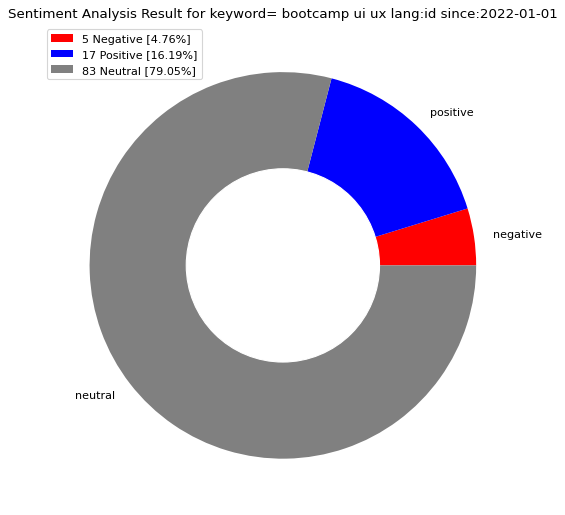

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Training UI/UX**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "training ui ux lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_traininguiux.csv')

In [ ]:
url='https://drive.google.com/file/d/19KjNzi_-d7arqKHrZjR2VscNyBdccmoW/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "training ui ux lang:id since:2022-01-01"

trainingUiUx = pd.read_csv(file_name)
trainingUiUx.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-16 14:28:50+00:00,kolektorstore,Tewas banget hari ini:\n\nPagi marahin supplie...
1,1,2022-04-15 03:35:43+00:00,kolektorstore,"Hari ini aku rada slow respon dulu ya, lagi ad..."
2,2,2022-03-24 14:55:42+00:00,dohyaun,going to take semi-rest (?) karena mau fokus k...
3,3,2022-03-13 16:14:09+00:00,Dailyriyanriyan,sistem yang gue buat ( sendirian ) dari sistem...
4,4,2022-02-04 10:00:01+00:00,myskill_id,Apa aja pintu masuk ke dunia UI/UX Design:\n\n...


In [ ]:
trainingUiUx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5 non-null      int64 
 1   Date        5 non-null      object
 2   User        5 non-null      object
 3   Tweet       5 non-null      object
dtypes: int64(1), object(3)
memory usage: 288.0+ bytes


In [ ]:
tw_list = trainingUiUx

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-16 14:28:50+00:00,kolektorstore,tewas banget hari ini:\n\npagi marahin supplie...,Tewas banget hari ini:\n\nPagi marahin supplie...
1,1,2022-04-15 03:35:43+00:00,kolektorstore,"hari ini aku rada slow respon dulu ya, lagi ad...","Hari ini aku rada slow respon dulu ya, lagi ad..."
2,2,2022-03-24 14:55:42+00:00,dohyaun,going to take semi-rest (?) karena mau fokus k...,going to take semi-rest (?) karena mau fokus k...
3,3,2022-03-13 16:14:09+00:00,Dailyriyanriyan,sistem yang gue buat ( sendirian ) dari sistem...,sistem yang gue buat ( sendirian ) dari sistem...
4,4,2022-02-04 10:00:01+00:00,myskill_id,apa aja pintu masuk ke dunia ui/ux design:\n\n...,Apa aja pintu masuk ke dunia UI/UX Design:\n\n...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-16 14:28:50+00:00,kolektorstore,tewas banget hari ini:\n\npagi marahin supplie...,0.0,0.0,negative,0.139,0.861,0.0,-0.6124
1,2022-04-15 03:35:43+00:00,kolektorstore,"hari ini aku rada slow respon dulu ya, lagi ad...",-0.3,0.4,neutral,0.000,1.000,0.0,0.0000
2,2022-03-24 14:55:42+00:00,dohyaun,going to take semi-rest (?) karena mau fokus k...,0.0,0.0,neutral,0.000,1.000,0.0,0.0000
3,2022-03-13 16:14:09+00:00,Dailyriyanriyan,sistem yang gue buat ( sendirian ) dari sistem...,0.0,0.0,neutral,0.000,1.000,0.0,0.0000
4,2022-02-04 10:00:01+00:00,myskill_id,apa aja pintu masuk ke dunia ui/ux design:\n\n...,0.1,0.1,neutral,0.000,1.000,0.0,0.0000


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-16 14:28:50+00:00,kolektorstore,tewas banget hari ini:\n\npagi marahin supplie...,0.0,0.0,negative,0.139,0.861,0.0,-0.6124


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
1,2022-04-15 03:35:43+00:00,kolektorstore,"hari ini aku rada slow respon dulu ya, lagi ad...",-0.3,0.4,neutral,0.0,1.0,0.0,0.0
2,2022-03-24 14:55:42+00:00,dohyaun,going to take semi-rest (?) karena mau fokus k...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
3,2022-03-13 16:14:09+00:00,Dailyriyanriyan,sistem yang gue buat ( sendirian ) dari sistem...,0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,1,20.0
neutral,4,80.0


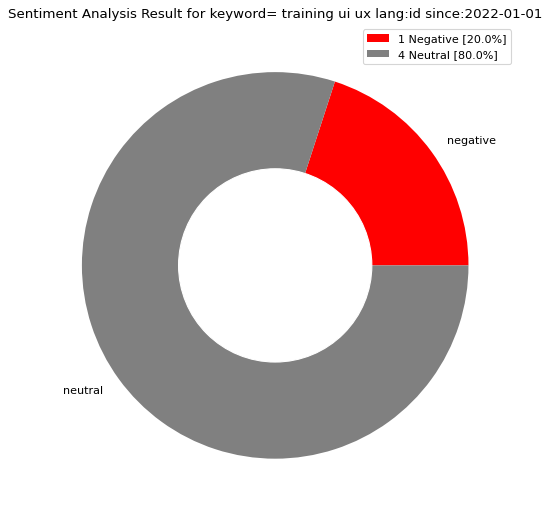

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart

neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']

neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Kelas UI/UX**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "kelas ui ux lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_kelasuiux.csv')

In [ ]:
url='https://drive.google.com/file/d/1W5r1CjAnD1PBFAO2-f77SNwDX0Hgy6hJ/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "kelas ui ux lang:id since:2022-01-01"

kelasUiUx = pd.read_csv(file_name)
kelasUiUx.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-15 14:10:07+00:00,fathoniofficial,@Galuhakhdandika Cara bikin UI/UX di Figma mas...
1,1,2022-04-15 06:04:57+00:00,idhamarsyd,@DesignersHalo love the way UIUX bisa diaplika...
2,2,2022-04-14 16:17:55+00:00,ARF_9,"@midnightcooler @worksfess Hello, boleh ikut u..."
3,3,2022-04-13 07:40:46+00:00,Nadzifatul321,@worksfess mau nanya kalau buat kelas yang fr...
4,4,2022-04-10 04:09:37+00:00,valsforjj,1. sistem informasi\n2. nggaa soalnya online t...


In [ ]:
kelasUiUx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  57 non-null     int64 
 1   Date        57 non-null     object
 2   User        57 non-null     object
 3   Tweet       57 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.9+ KB


In [ ]:
tw_list = kelasUiUx

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-15 14:10:07+00:00,fathoniofficial,"cara bikin ui/ux di figma mas, soalnya mnrtku...",@Galuhakhdandika Cara bikin UI/UX di Figma mas...
1,1,2022-04-15 06:04:57+00:00,idhamarsyd,love the way uiux bisa diaplikasiin ke hampir...,@DesignersHalo love the way UIUX bisa diaplika...
2,2,2022-04-14 16:17:55+00:00,ARF_9,"hello, boleh ikut untuk ui /ux course classn...","@midnightcooler @worksfess Hello, boleh ikut u..."
3,3,2022-04-13 07:40:46+00:00,Nadzifatul321,mau nanya kalau buat kelas yang free khusus ...,@worksfess mau nanya kalau buat kelas yang fr...
4,4,2022-04-10 04:09:37+00:00,valsforjj,1. sistem informasi\n2. nggaa soalnya online t...,1. sistem informasi\n2. nggaa soalnya online t...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-15 14:10:07+00:00,fathoniofficial,"cara bikin ui/ux di figma mas, soalnya mnrtku...",0.00,0.00,neutral,0.000,1.000,0.000,0.0000
1,2022-04-15 06:04:57+00:00,idhamarsyd,love the way uiux bisa diaplikasiin ke hampir...,0.09,0.44,positive,0.119,0.714,0.167,0.5267
2,2022-04-14 16:17:55+00:00,ARF_9,"hello, boleh ikut untuk ui /ux course classn...",0.00,0.00,neutral,0.000,1.000,0.000,0.0000
3,2022-04-13 07:40:46+00:00,Nadzifatul321,mau nanya kalau buat kelas yang free khusus ...,0.40,0.80,positive,0.000,0.845,0.155,0.5106
4,2022-04-10 04:09:37+00:00,valsforjj,1. sistem informasi\n2. nggaa soalnya online t...,0.00,0.00,positive,0.000,0.950,0.050,0.3544
5,2022-04-09 12:24:38+00:00,_doubledy,"aku suka design sejak kelas 2 sma, lalu lanju...",0.00,0.00,neutral,0.000,1.000,0.000,0.0000
6,2022-04-08 15:37:05+00:00,Sapimelahirkan2,"mau banget, karna saya lagi nekunin bidang ui...",0.00,0.00,positive,0.000,0.972,0.028,0.0516
7,2022-04-08 15:03:30+00:00,dianihsn,"dengan ikutan kelas, semoga saja bisa menjawa...",0.70,0.60,positive,0.070,0.755,0.174,0.4588
8,2022-04-08 12:44:02+00:00,royanbaeh,"belajar buat mock up, terus ke adobe xd, samp...",0.00,0.00,positive,0.069,0.837,0.094,0.2500
9,2022-04-08 09:24:57+00:00,crkdyoun6,mulai belajar ui/ux design karena dari kuliah...,0.00,0.00,positive,0.000,0.973,0.027,0.0516


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
1,2022-04-15 06:04:57+00:00,idhamarsyd,love the way uiux bisa diaplikasiin ke hampir...,0.09,0.44,positive,0.119,0.714,0.167,0.5267
3,2022-04-13 07:40:46+00:00,Nadzifatul321,mau nanya kalau buat kelas yang free khusus ...,0.40,0.80,positive,0.000,0.845,0.155,0.5106
4,2022-04-10 04:09:37+00:00,valsforjj,1. sistem informasi\n2. nggaa soalnya online t...,0.00,0.00,positive,0.000,0.950,0.050,0.3544


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
22,2022-03-08 06:30:56+00:00,nyacatchan,*me ikut kelas ui/ux\nme: .....\nme: .....\ndo...,-0.20,0.283333,negative,0.113,0.887,0.0,-0.5106
43,2022-01-28 12:35:48+00:00,mightyzorian,alterra academy kga mau nerima apply-an kelas ...,-0.75,1.000000,negative,0.225,0.775,0.0,-0.4404


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-15 14:10:07+00:00,fathoniofficial,"cara bikin ui/ux di figma mas, soalnya mnrtku...",0.0,0.0,neutral,0.0,1.0,0.0,0.0
2,2022-04-14 16:17:55+00:00,ARF_9,"hello, boleh ikut untuk ui /ux course classn...",0.0,0.0,neutral,0.0,1.0,0.0,0.0
5,2022-04-09 12:24:38+00:00,_doubledy,"aku suka design sejak kelas 2 sma, lalu lanju...",0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,2,3.51
positive,20,35.09
neutral,35,61.40


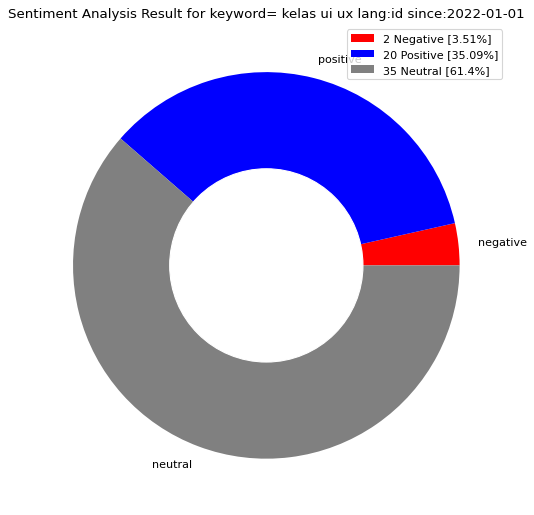

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Les UI/UX**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "les ui ux lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000

for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_lesuiux.csv')

In [ ]:
url='https://drive.google.com/file/d/1GL1MMYDsSJ89Ej8ZIgWIvfNC9QGLUMGq/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "les ui ux lang:id since:2022-01-01"

lesUiUx = pd.read_csv(file_name)
lesUiUx.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-03-10 08:49:38+00:00,alyastruggle,gw kenal salah satu temen cewe gw yg sedari du...
1,1,2022-01-27 10:03:53+00:00,septgurvg,ada les buat belajar UI/UX ga ya
2,2,2022-01-23 13:23:35+00:00,fitririzkin,Mau ambil course ui/ux eh jadwalnya bentrok mu...
3,3,2022-01-21 03:24:58+00:00,tiwnkerbeii,ingetin gua buat les ui/ux abis ini yamfun pus...
4,4,2022-01-19 17:08:52+00:00,himeyyy_,Taun kemaren ikut les sna sama software engine...


In [ ]:
lesUiUx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6 non-null      int64 
 1   Date        6 non-null      object
 2   User        6 non-null      object
 3   Tweet       6 non-null      object
dtypes: int64(1), object(3)
memory usage: 320.0+ bytes


In [ ]:
tw_list = lesUiUx

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-03-10 08:49:38+00:00,alyastruggle,gw kenal salah satu temen cewe gw yg sedari du...,gw kenal salah satu temen cewe gw yg sedari du...
1,1,2022-01-27 10:03:53+00:00,septgurvg,ada les buat belajar ui/ux ga ya,ada les buat belajar UI/UX ga ya
2,2,2022-01-23 13:23:35+00:00,fitririzkin,mau ambil course ui/ux eh jadwalnya bentrok mu...,Mau ambil course ui/ux eh jadwalnya bentrok mu...
3,3,2022-01-21 03:24:58+00:00,tiwnkerbeii,ingetin gua buat les ui/ux abis ini yamfun pus...,ingetin gua buat les ui/ux abis ini yamfun pus...
4,4,2022-01-19 17:08:52+00:00,himeyyy_,taun kemaren ikut les sna sama software engine...,Taun kemaren ikut les sna sama software engine...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-03-10 08:49:38+00:00,alyastruggle,gw kenal salah satu temen cewe gw yg sedari du...,0.000000,0.00,neutral,0.000,1.000,0.0,0.0000
1,2022-01-27 10:03:53+00:00,septgurvg,ada les buat belajar ui/ux ga ya,0.000000,0.00,neutral,0.000,1.000,0.0,0.0000
2,2022-01-23 13:23:35+00:00,fitririzkin,mau ambil course ui/ux eh jadwalnya bentrok mu...,0.000000,0.00,neutral,0.000,1.000,0.0,0.0000
3,2022-01-21 03:24:58+00:00,tiwnkerbeii,ingetin gua buat les ui/ux abis ini yamfun pus...,0.000000,0.00,neutral,0.000,1.000,0.0,0.0000
4,2022-01-19 17:08:52+00:00,himeyyy_,taun kemaren ikut les sna sama software engine...,-0.750000,1.00,neutral,0.000,1.000,0.0,0.0000
5,2022-01-18 16:26:22+00:00,gnwn_d,apa hubungannya high risk high return dgn baru...,0.106667,0.46,negative,0.196,0.804,0.0,-0.8176


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
5,2022-01-18 16:26:22+00:00,gnwn_d,apa hubungannya high risk high return dgn baru...,0.106667,0.46,negative,0.196,0.804,0.0,-0.8176


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-03-10 08:49:38+00:00,alyastruggle,gw kenal salah satu temen cewe gw yg sedari du...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
1,2022-01-27 10:03:53+00:00,septgurvg,ada les buat belajar ui/ux ga ya,0.0,0.0,neutral,0.0,1.0,0.0,0.0
2,2022-01-23 13:23:35+00:00,fitririzkin,mau ambil course ui/ux eh jadwalnya bentrok mu...,0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,1,16.67
neutral,5,83.33


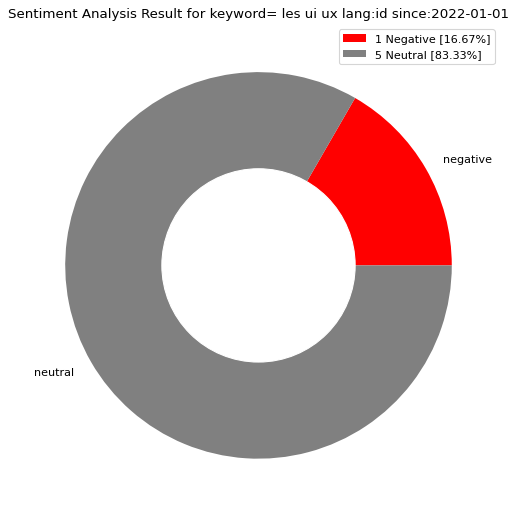

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart

neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']

neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Pelatihan UI/UX**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "pelatihan ui ux lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_pelatihanuiux.csv')

In [ ]:
url='https://drive.google.com/file/d/1uHBb10LRDv4FORoOGLZUzEBHyfeyAdUX/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "pelatihan ui ux lang:id since:2022-01-01"

pelatihanUiUx = pd.read_csv(file_name)
pelatihanUiUx.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-16 18:24:26+00:00,mfauziproject_,@latifaskaa @buildwithangga ada juga pelatihan...
1,1,2022-04-13 07:07:19+00:00,marchmeIIow,ini cita-cita jadi nyasar. punya pengalaman ja...
2,2,2022-04-13 01:05:01+00:00,eventsurabaya,Hai Digipals!\nPendaftaran batch 1 bootcamp UI...
3,3,2022-04-07 07:30:00+00:00,worksfess,Work! Boleh tolong rekomendasiin platform utk ...
4,4,2022-04-06 22:55:51+00:00,cIoudykuma,"@worksfess Aku, ngelamar ui ux tp pengalaman m..."


In [ ]:
pelatihanUiUx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  35 non-null     int64 
 1   Date        35 non-null     object
 2   User        35 non-null     object
 3   Tweet       35 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.2+ KB


In [ ]:
tw_list = pelatihanUiUx

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-16 18:24:26+00:00,mfauziproject_,ada juga pelatihan gratis ka dr kominfo. nam...,@latifaskaa @buildwithangga ada juga pelatihan...
1,1,2022-04-13 07:07:19+00:00,marchmeIIow,ini cita-cita jadi nyasar. punya pengalaman ja...,ini cita-cita jadi nyasar. punya pengalaman ja...
2,2,2022-04-13 01:05:01+00:00,eventsurabaya,hai digipals!\npendaftaran batch 1 bootcamp ui...,Hai Digipals!\nPendaftaran batch 1 bootcamp UI...
3,3,2022-04-07 07:30:00+00:00,worksfess,work! boleh tolong rekomendasiin platform utk ...,Work! Boleh tolong rekomendasiin platform utk ...
4,4,2022-04-06 22:55:51+00:00,cIoudykuma,"aku, ngelamar ui ux tp pengalaman magangku di...","@worksfess Aku, ngelamar ui ux tp pengalaman m..."


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-16 18:24:26+00:00,mfauziproject_,ada juga pelatihan gratis ka dr kominfo. nam...,0.0,0.0,positive,0.000,0.765,0.235,0.4588
1,2022-04-13 07:07:19+00:00,marchmeIIow,ini cita-cita jadi nyasar. punya pengalaman ja...,0.0,0.0,neutral,0.000,1.000,0.000,0.0000
2,2022-04-13 01:05:01+00:00,eventsurabaya,hai digipals!\npendaftaran batch 1 bootcamp ui...,0.0,0.5,neutral,0.000,1.000,0.000,0.0000
3,2022-04-07 07:30:00+00:00,worksfess,work! boleh tolong rekomendasiin platform utk ...,0.0,0.0,neutral,0.000,1.000,0.000,0.0000
4,2022-04-06 22:55:51+00:00,cIoudykuma,"aku, ngelamar ui ux tp pengalaman magangku di...",0.0,0.0,neutral,0.000,1.000,0.000,0.0000
5,2022-04-02 02:50:01+00:00,worksfess,"work! rencana mau ambil pelatihan ui/ux, denga...",0.0,0.0,positive,0.000,0.814,0.186,0.6696
6,2022-04-02 02:48:46+00:00,karirfess,"kr! rencana mau ambil pelatihan ui/ux, dengan ...",0.0,0.0,positive,0.000,0.814,0.186,0.6696
7,2022-03-30 12:12:11+00:00,codingfess,g incubation data science ui/ux design batch 3...,0.0,0.0,neutral,0.000,1.000,0.000,0.0000
8,2022-03-27 06:55:40+00:00,karirfess,kr! guys info pelatihan/bootcamp ui/ux gratis ...,0.0,0.0,positive,0.000,0.904,0.096,0.1260
9,2022-03-26 07:08:25+00:00,masbenx,ux nya masi nyaman yang livin biru..\ndevelop...,-0.2,0.2,negative,0.085,0.915,0.000,-0.4019


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-16 18:24:26+00:00,mfauziproject_,ada juga pelatihan gratis ka dr kominfo. nam...,0.0,0.0,positive,0.0,0.765,0.235,0.4588
5,2022-04-02 02:50:01+00:00,worksfess,"work! rencana mau ambil pelatihan ui/ux, denga...",0.0,0.0,positive,0.0,0.814,0.186,0.6696
6,2022-04-02 02:48:46+00:00,karirfess,"kr! rencana mau ambil pelatihan ui/ux, dengan ...",0.0,0.0,positive,0.0,0.814,0.186,0.6696


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
9,2022-03-26 07:08:25+00:00,masbenx,ux nya masi nyaman yang livin biru..\ndevelop...,-0.2,0.2,negative,0.085,0.915,0.0,-0.4019
33,2022-01-07 03:24:27+00:00,pxsfun,gapapa nder. tapi mungkin km bisa pelajari ui...,0.0,0.0,negative,0.062,0.938,0.0,-0.3400


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
1,2022-04-13 07:07:19+00:00,marchmeIIow,ini cita-cita jadi nyasar. punya pengalaman ja...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
2,2022-04-13 01:05:01+00:00,eventsurabaya,hai digipals!\npendaftaran batch 1 bootcamp ui...,0.0,0.5,neutral,0.0,1.0,0.0,0.0
3,2022-04-07 07:30:00+00:00,worksfess,work! boleh tolong rekomendasiin platform utk ...,0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,2,5.71
positive,10,28.57
neutral,23,65.71


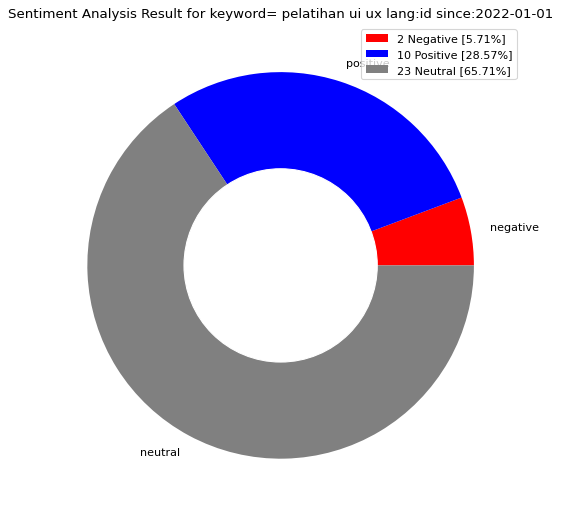

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Belajar UI/UX**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "belajar ui ux lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_belajaruiux.csv')

In [ ]:
url='https://drive.google.com/file/d/17EWcdsjWMnse-2xEA7JS-eIdohN_N2Qf/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "belajar ui ux lang:id since:2022-01-01"

belajarUiUx = pd.read_csv(file_name)
belajarUiUx.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-19 09:58:45+00:00,meilbeurres,kak dwinawan sangat membantu gue bgt dalam pro...
1,1,2022-04-19 05:29:18+00:00,collegemenfess,Mau belajar ui ux mandiri tiap smt selalu terh...
2,2,2022-04-18 18:56:49+00:00,diahputrilstari,Belajar UI/UX apa ya? Hmmm roadmapnya gimana ya
3,3,2022-04-17 09:06:14+00:00,mfauziproject_,mau coba dokumentasi belajar ui/ux via vidio
4,4,2022-04-16 15:25:00+00:00,worksfess,"Work! Aku kepikiran switch karier, pengennya k..."


In [ ]:
belajarUiUx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  515 non-null    int64 
 1   Date        515 non-null    object
 2   User        515 non-null    object
 3   Tweet       515 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.2+ KB


In [ ]:
tw_list = belajarUiUx

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-19 09:58:45+00:00,meilbeurres,kak dwinawan sangat membantu gue bgt dalam pro...,kak dwinawan sangat membantu gue bgt dalam pro...
1,1,2022-04-19 05:29:18+00:00,collegemenfess,mau belajar ui ux mandiri tiap smt selalu terh...,Mau belajar ui ux mandiri tiap smt selalu terh...
2,2,2022-04-18 18:56:49+00:00,diahputrilstari,belajar ui/ux apa ya? hmmm roadmapnya gimana ya,Belajar UI/UX apa ya? Hmmm roadmapnya gimana ya
3,3,2022-04-17 09:06:14+00:00,mfauziproject_,mau coba dokumentasi belajar ui/ux via vidio,mau coba dokumentasi belajar ui/ux via vidio
4,4,2022-04-16 15:25:00+00:00,worksfess,"work! aku kepikiran switch karier, pengennya k...","Work! Aku kepikiran switch karier, pengennya k..."


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-19 09:58:45+00:00,meilbeurres,kak dwinawan sangat membantu gue bgt dalam pro...,0.0,0.000,neutral,0.0,1.000,0.000,0.0000
1,2022-04-19 05:29:18+00:00,collegemenfess,mau belajar ui ux mandiri tiap smt selalu terh...,0.0,0.000,neutral,0.0,1.000,0.000,0.0000
2,2022-04-18 18:56:49+00:00,diahputrilstari,belajar ui/ux apa ya? hmmm roadmapnya gimana ya,0.0,0.000,neutral,0.0,1.000,0.000,0.0000
3,2022-04-17 09:06:14+00:00,mfauziproject_,mau coba dokumentasi belajar ui/ux via vidio,0.0,0.000,neutral,0.0,1.000,0.000,0.0000
4,2022-04-16 15:25:00+00:00,worksfess,"work! aku kepikiran switch karier, pengennya k...",0.0,0.125,neutral,0.0,1.000,0.000,0.0000
5,2022-04-16 14:00:54+00:00,latifaskaa,saran bootcamp ui/ux gratis ?\n\nbelum ada sih...,0.0,0.125,positive,0.0,0.965,0.035,0.0516
6,2022-04-16 13:00:05+00:00,DesignersHalo,[ui ux whiteboard test]\n\nmungkin sebagian te...,0.0,0.000,neutral,0.0,1.000,0.000,0.0000
7,2022-04-16 11:37:26+00:00,aqshalrzq_,ui ux design sama suka belajar analisa di dun...,0.0,0.000,neutral,0.0,1.000,0.000,0.0000
8,2022-04-16 08:49:03+00:00,ilhmkl,"sekrg lagi belajar ui/ux sih hehe, msih bel...",0.0,0.000,neutral,0.0,1.000,0.000,0.0000
9,2022-04-16 07:26:47+00:00,ryan_i2,oh bukan sih tadi kan dia bilang web progra...,0.1,1.000,positive,0.0,0.886,0.114,0.7096


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
5,2022-04-16 14:00:54+00:00,latifaskaa,saran bootcamp ui/ux gratis ?\n\nbelum ada sih...,0.00,0.125,positive,0.000,0.965,0.035,0.0516
9,2022-04-16 07:26:47+00:00,ryan_i2,oh bukan sih tadi kan dia bilang web progra...,0.10,1.000,positive,0.000,0.886,0.114,0.7096
10,2022-04-16 05:25:26+00:00,amperson9,"love: selain emg suka desain, ada kepuasan te...",-0.15,0.750,positive,0.074,0.842,0.084,0.1280


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
13,2022-04-16 04:45:12+00:00,JustBennnnn,hate : reosources buat belajar kbanyakan masi...,-0.80,0.90,negative,0.144,0.856,0.000,-0.5719
26,2022-04-15 06:01:04+00:00,messayusyaha,"love: aku nemuin harapan melalui ux, karena d...",-0.15,0.75,negative,0.121,0.795,0.083,-0.2263
43,2022-04-14 15:28:17+00:00,pknceu,"halooo kak, aku mauuu bgtbgtbgt. lg mau belaj...",-0.75,1.00,negative,0.146,0.854,0.000,-0.4404


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-19 09:58:45+00:00,meilbeurres,kak dwinawan sangat membantu gue bgt dalam pro...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
1,2022-04-19 05:29:18+00:00,collegemenfess,mau belajar ui ux mandiri tiap smt selalu terh...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
2,2022-04-18 18:56:49+00:00,diahputrilstari,belajar ui/ux apa ya? hmmm roadmapnya gimana ya,0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,32,6.21
positive,118,22.91
neutral,365,70.87


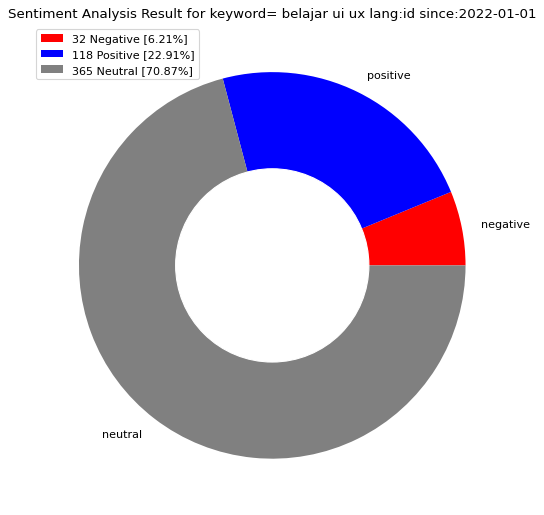

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()